In [1]:
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

%matplotlib inline

In [2]:
# Loading the data
covid = pd.read_csv( './data/covid19_colombia.csv' )

In [3]:
# Getting the size of the df
covid.shape

(15574, 16)

In [4]:
# Add a new column for asimptomatic observations
covid.loc[ covid[ 'FIS' ] == 'Asintomático', 'Asintomático' ] = True
covid.loc[ covid[ 'FIS' ] != 'Asintomático', 'Asintomático' ] = False

In [5]:
# Casting date columns
covid[ 'Fecha de notificación' ] = pd.to_datetime( covid[ 'Fecha de notificación' ] )
covid[ 'FIS' ] = pd.to_datetime( covid[ 'FIS' ], errors = 'coerce' )
covid[ 'Fecha de muerte' ] = pd.to_datetime( covid[ 'Fecha de muerte' ], errors = 'coerce' )
covid[ 'Fecha diagnostico' ] = pd.to_datetime( covid[ 'Fecha diagnostico' ] )
covid[ 'Fecha recuperado' ] = pd.to_datetime( covid[ 'Fecha recuperado' ], errors = 'coerce' )
covid[ 'fecha reporte web' ] = pd.to_datetime( covid[ 'fecha reporte web' ] )

In [6]:
# Unifying values for sex
covid[ 'Sexo' ].replace( { 'm': 'M', 'f': 'F' }, inplace = True )

In [52]:
# Unifying values for status
covid[ 'Estado' ].replace( { 'leve': 'Leve', 'LEVE': 'Leve' }, inplace = True )

In [8]:
# Unifying values for procedence
covid[ 'País de procedencia' ].replace( { '-   -': None }, inplace = True )

In [9]:
covid.loc[ covid[ 'Fecha recuperado' ].notnull(), 'Recuperado' ] = True
covid.loc[ covid[ 'Fecha recuperado' ].isnull(), 'Recuperado' ] = False

In [10]:
covid.loc[ covid[ 'Fecha de muerte' ].notnull(), 'Fallecido' ] = True
covid.loc[ covid[ 'Fecha de muerte' ].isnull(), 'Fallecido' ] = False

In [11]:
# Getting the column types
covid.dtypes

ID de caso                           int64
Fecha de notificación       datetime64[ns]
Codigo DIVIPOLA                      int64
Ciudad de ubicación                 object
Departamento o Distrito             object
atención                            object
Edad                                 int64
Sexo                                object
Tipo                                object
Estado                              object
País de procedencia                 object
FIS                         datetime64[ns]
Fecha de muerte             datetime64[ns]
Fecha diagnostico           datetime64[ns]
Fecha recuperado            datetime64[ns]
fecha reporte web           datetime64[ns]
Asintomático                          bool
Recuperado                            bool
Fallecido                             bool
dtype: object

In [12]:
# Showing the firts rows
covid.head()

,ID de caso,Fecha de notificación,Codigo DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web,Asintomático,Recuperado,Fallecido
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,Italia,2020-02-27,NaT,2020-03-06,2020-03-13,2020-03-06,False,True,False
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,España,2020-03-04,NaT,2020-03-09,2020-03-19,2020-03-09,False,True,False
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,España,2020-02-29,NaT,2020-03-09,2020-03-15,2020-03-09,False,True,False
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,Colombia,2020-03-06,NaT,2020-03-11,2020-03-26,2020-03-11,False,True,False
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,Colombia,2020-03-08,NaT,2020-03-11,2020-03-23,2020-03-11,False,True,False


In [13]:
# How many observations have null atention
covid.loc[ covid[ 'atención' ].isnull() ].shape

(18, 19)

In [14]:
# How many observations have null atention
covid.loc[ covid[ 'Estado' ].isnull() ].shape

(20, 19)

# Indicators

In [15]:
covid[ 'ID de caso' ].nunique()

15574

In [16]:
covid.loc[ covid[ 'Recuperado' ] == True ].shape[ 0 ]

3752

In [17]:
covid.loc[ covid[ 'Fallecido' ] == True ].shape[ 0 ]

586

In [18]:
covid.loc[ ( covid[ 'atención' ] == 'Hospital' ) ].shape[ 0 ]

874

In [19]:
covid.loc[ ( covid[ 'atención' ] == 'Hospital UCI' ) ].shape[ 0 ]

155

# Time series

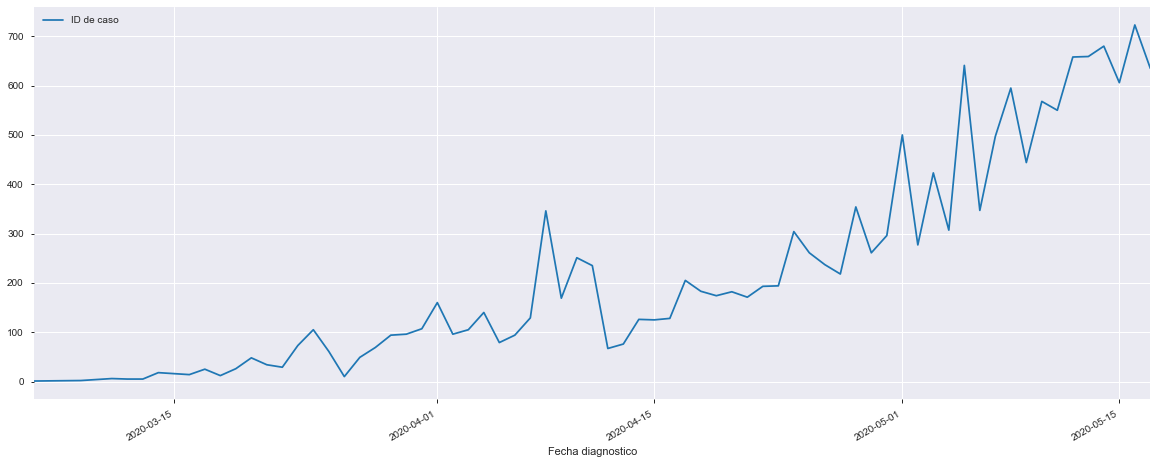

In [20]:
# Plotting diagnosed cases by day
covid.groupby( 'Fecha diagnostico' ).agg( { 'ID de caso': 'count' } ).plot( figsize = ( 20, 8 ) )

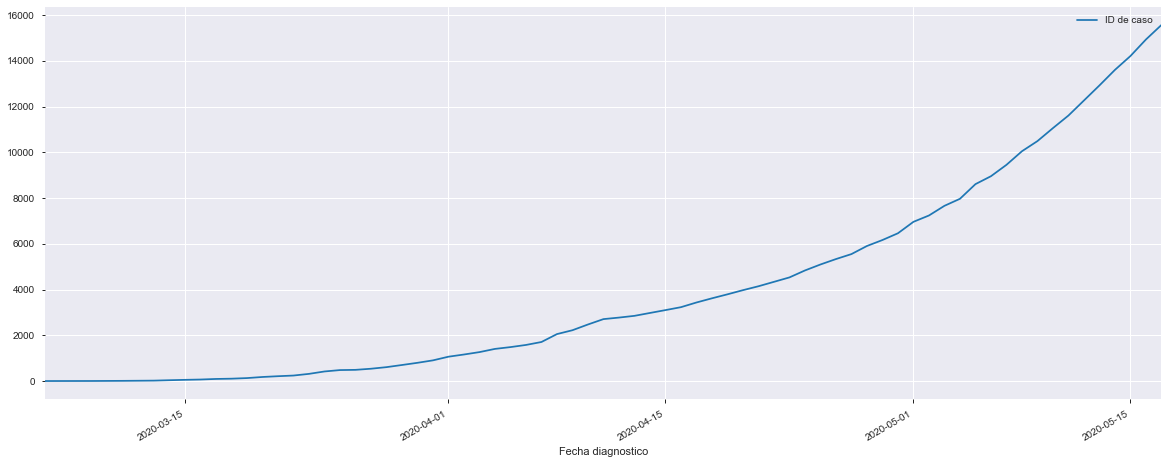

In [21]:
# Plotting diagnosed cases by day (cumulative sum)
covid.groupby( 'Fecha diagnostico' ).agg( { 'ID de caso': 'count' } ).cumsum().plot( figsize = ( 20, 8 ) )

In [22]:
# Preparing and merging the groupings in one dataframe

diagnosed = covid.groupby( 'Fecha diagnostico' ) \
    .agg( { 'ID de caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha diagnostico': 'Fecha', 'ID de caso': 'Diagnosticados' } )

recovered = covid.groupby( 'Fecha recuperado' )  \
    .agg( { 'ID de caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha recuperado': 'Fecha', 'ID de caso': 'Recuperados' } )

deaths = covid.groupby( 'Fecha de muerte' )  \
    .agg( { 'ID de caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha de muerte': 'Fecha', 'ID de caso': 'Fallecidos' } )

infections = diagnosed.merge( recovered, how = 'outer', left_index = True, right_index = True )
infections = infections.merge( deaths, how = 'outer', left_index = True, right_index = True )
infections.fillna( 0, inplace = True )

In [23]:
infections.drop( infections.tail( 1 ).index, inplace = True )

In [24]:
infections.tail()

,Diagnosticados,Recuperados,Fallecidos
2020-05-12,12271,3485.0,552.0
2020-05-13,12930,3627.0,560.0
2020-05-14,13610,3665.0,572.0
2020-05-15,14216,3705.0,581.0
2020-05-16,14939,3750.0,586.0


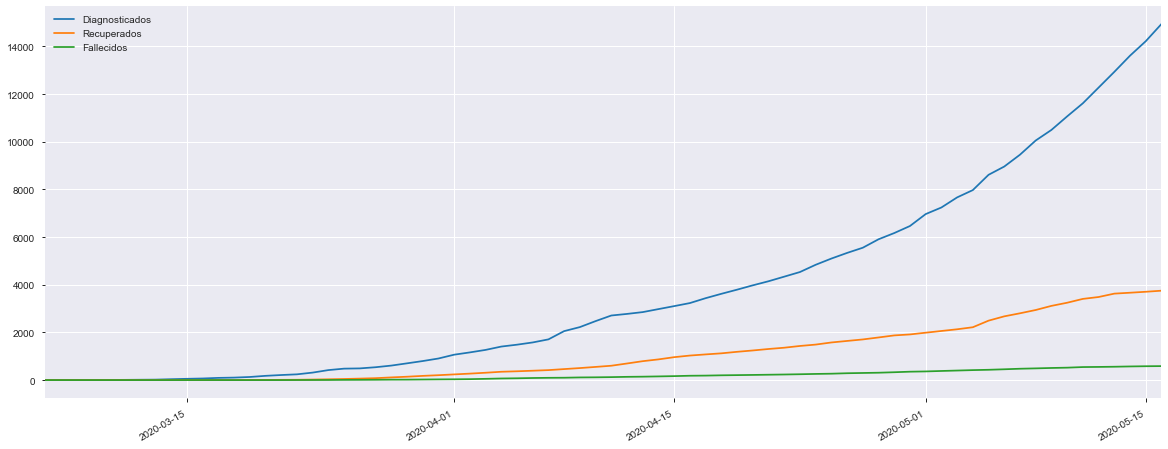

In [25]:
# Plotting diagnosed and recovered cases by day
infections.plot( figsize = ( 20, 8 ) )

In [26]:
# Calculating the difference between diagnosed and recovered cases
infections[ 'Casos activos' ] = infections[ 'Diagnosticados' ] - infections[ 'Recuperados' ]

In [27]:
infections.tail()

,Diagnosticados,Recuperados,Fallecidos,Casos activos
2020-05-12,12271,3485.0,552.0,8786.0
2020-05-13,12930,3627.0,560.0,9303.0
2020-05-14,13610,3665.0,572.0,9945.0
2020-05-15,14216,3705.0,581.0,10511.0
2020-05-16,14939,3750.0,586.0,11189.0


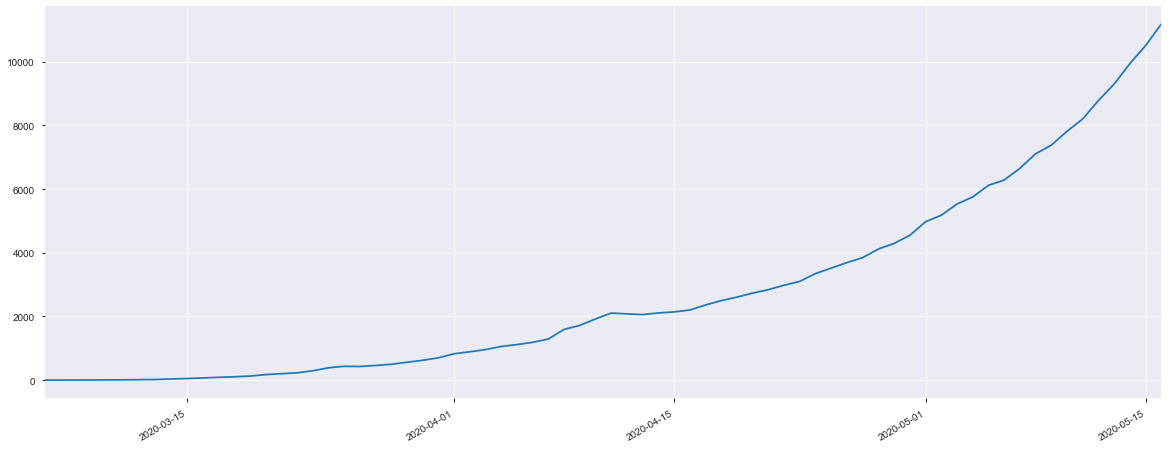

In [28]:
# Plotting difference cases by day
infections[ 'Casos activos' ].plot( figsize = ( 20, 8 ) )

# Geo

In [54]:
covid.head()

,ID de caso,Fecha de notificación,Codigo DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web,Asintomático,Recuperado,Fallecido,codigo_departamento
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,Italia,2020-02-27,NaT,2020-03-06,2020-03-13,2020-03-06,False,True,False,11
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,España,2020-03-04,NaT,2020-03-09,2020-03-19,2020-03-09,False,True,False,76
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,España,2020-02-29,NaT,2020-03-09,2020-03-15,2020-03-09,False,True,False,5
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,Colombia,2020-03-06,NaT,2020-03-11,2020-03-26,2020-03-11,False,True,False,5
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,Colombia,2020-03-08,NaT,2020-03-11,2020-03-23,2020-03-11,False,True,False,5


In [55]:
covid[ 'atención' ].value_counts( dropna = False )

Casa            10202
Recuperado       3751
Hospital          874
Fallecido         574
Hospital UCI      155
NaN                18
Name: atención, dtype: int64

In [47]:
def extract_depto( x ):
    x = str( x )[ :-3 ]
    try:
        return int( x )
    except:
        return 0
    
covid[ 'codigo_departamento' ] = covid[ 'Codigo DIVIPOLA' ].apply( lambda x: extract_depto( x ) )

In [73]:
cases_by_depto = covid.loc[ ~covid[ 'atención' ].isin( [ 'Recuperado', 'Fallecido' ] ) ].groupby( 'codigo_departamento' ).agg( { 'ID de caso': 'count' } ).reset_index().rename( columns = { 'ID de caso': 'Casos' } )

In [74]:
cases_by_depto.head()

,codigo_departamento,Casos
0,0,32
1,5,202
2,8,1578
3,11,3898
4,13,1079


In [75]:
departamentos = gpd.read_file( './data/geo/departamentos.json' )

In [76]:
cases_by_depto = departamentos.merge( cases_by_depto, how = 'left', on = 'codigo_departamento' )
cases_by_depto[ 'Casos' ] = cases_by_depto[ 'Casos' ].fillna( 0 )

In [80]:
cases_by_depto

,departamento,codigo_departamento,geometry,Casos
0,SAN ANDRÉS PROVIDENCIA Y SANTA CATALINA,88,"MULTIPOLYGON (((-81.70399 12.59487, -81.70394 ...",16.0
1,CAUCA,19,"MULTIPOLYGON (((-76.44619 3.31639, -76.44597 3...",34.0
2,VALLE DEL CAUCA,76,"MULTIPOLYGON (((-76.08076 5.04322, -76.08033 5...",1083.0
3,ATLÁNTICO,8,"MULTIPOLYGON (((-74.83855 11.06027, -74.83297 ...",1578.0
4,RISARALDA,66,"MULTIPOLYGON (((-76.00825 5.56368, -76.00765 5...",75.0
5,ANTIOQUIA,5,"MULTIPOLYGON (((-76.41356 8.74766, -76.41269 8...",202.0
6,QUINDÍO,63,"MULTIPOLYGON (((-75.70002 4.72006, -75.69970 4...",19.0
7,BOLÍVAR,13,"MULTIPOLYGON (((-75.25555 10.79960, -75.25546 ...",1079.0
8,CAQUETÁ,18,"MULTIPOLYGON (((-74.89423 2.95852, -74.89410 2...",18.0
9,MAGDALENA,47,"MULTIPOLYGON (((-74.04046 11.34612, -74.04084 ...",275.0


In [79]:
cases_by_depto.to_file( './colombia-map/departamentos.json', driver ='GeoJSON' )

In [ ]:
covid[ 'dias_para_diagnostico' ] = ( covid[ 'Fecha_diagnostico' ] - covid[ 'FIS' ] ).dt.days

In [ ]:
covid[ 'Estado' ].value_counts( dropna = False )

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'dias_para_diagnostico', y = 'Estado' )

In [ ]:
covid[ 'atención' ].value_counts( dropna = False )

In [ ]:
covid.loc[ covid[ 'atención' ] == 'Casa' ][ 'Edad' ].quantile( [ 0.25, 0.5, 0.75 ] )

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'Edad', y = 'atención' )

In [ ]:
covid.loc[ covid[ 'Tipo' ] == 'Importado' ].groupby( 'Fecha_diagnostico' ).agg( { 'ID_de_caso': 'count' } ).plot( kind = 'bar', figsize = ( 20, 8 ) )

In [ ]:
# Preparing and merging the groupings in one dataframe

diagnosed = covid.loc[ covid[ 'Tipo' ] == 'Importado' ] \
    .groupby( 'Fecha_diagnostico' ) \
    .agg( { 'ID_de_caso': 'count' } ) \
    .rename( columns = { 'Fecha_diagnostico': 'Fecha', 'ID_de_caso': 'Diagnosticados' } )

recovered = covid.loc[ covid[ 'Tipo' ] == 'Importado' ] \
    .groupby( 'FIS' ) \
    .agg( { 'ID_de_caso': 'count' } ) \
    .rename( columns = { 'Fecha_diagnostico': 'Fecha', 'ID_de_caso': 'Inicio de sintomas' } )

infections = diagnosed.merge( recovered, how = 'outer', left_index = True, right_index = True )
infections.fillna( 0, inplace = True )

In [ ]:
infections.tail()

In [ ]:
f, axarr = plt.subplots( 2, sharex = True, figsize = ( 20, 10 ) )
axarr[ 0 ].set_title( 'Fecha de diagnostico de casos importados' )
infections[ 'Diagnosticados' ].plot( kind = 'bar', ax = axarr[ 0 ] )
axarr[ 1 ].set_title( 'Fecha de inicio de sintomas de casos importados' )
infections[ 'Inicio de sintomas' ].plot( kind = 'bar', ax = axarr[ 1 ] )
axarr[ 0 ].axvline( x = 23.5, color = 'r', linestyle = '--' )
axarr[ 1 ].axvline( x = 23.5, color = 'r', linestyle = '--' )

In [ ]:
covid[ 'Estado' ].value_counts( dropna = False )

In [ ]:
covid[ 'dias_para_recuperarse' ] = ( covid[ 'Fecha_recuperado' ] - covid[ 'Fecha_diagnostico' ] ).dt.days

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'dias_para_recuperarse', y = 'Estado' )

In [ ]:
covid.loc[ covid[ 'dias_para_recuperarse' ] < 0 ]

In [ ]:
covid.head()

In [ ]:
covid.to_csv( './data/covid_clean.csv', index = False, sep = ',' )

In [ ]:
infections.reset_index().to_csv( './data/covid_groups.csv', index = False, sep = ',' )

In [ ]:
departamentos.to_file( './data/departamentos_groups.json', driver = 'GeoJSON' )